In [1]:
import pandas as pd

df_selected = pd.read_csv("../lemmatizers/corpus_lemmatized_cleaned_twice.csv", encoding="utf-8")

In [2]:
print(df_selected.shape)
df_selected.head()

(208875, 3)


,Product,Consumer complaint narrative,Issue
0,"Payday loan, title loan, or personal loan",they would not let me pay my loan off day befo...,Problem with the payoff process at the end of ...
1,"Payday loan, title loan, or personal loan",service finance are liar and are charging me i...,Charged fees or interest you didn't expect
2,Checking or savings account,over draft fee due to fraudulent charge submit...,Problem caused by your funds being low
3,Vehicle loan or lease,on i signed a car loan agreement to finance my...,Problems at the end of the loan or lease
4,"Money transfer, virtual currency, or money ser...",we hired and debt collection to handle collect...,Fraud or scam


In case of nulls (should be solved now):

In [3]:
df_selected = df_selected.dropna()

---

__Functions to clean the Consumer complaint narrative__

In [4]:
import re
import string

def clean_url(complaint):
    # to do: more regex url garbage matching
    complaint = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    complaint = re.sub('https? ?: ?// ?(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    return complaint

# Remove punctuation from complaint
def clean_punctuation(complaint):
    complaint = re.sub('[%s]' % re.escape(string.punctuation), '', complaint)
    return complaint

# Remove non-sensical characters from complaint
def clean_nonsense(complaint):
    complaint = re.sub('[''""...]', '', complaint)
    complaint = re.sub('\n', '', complaint)
    return complaint

# Remove censored words from complaint
def clean_censored(complaint):
    complaint = re.sub('[XXXX]', '', complaint)
    return complaint

# Turn everything into lowercase
def clean_lowercase(complaint):
    complaint = complaint.lower()
    return complaint

# Remove numbers from complaint
def clean_numbers(complaint):
    complaint = re.sub('\w*\d\w', '', complaint)
    return complaint

__Application of narrative cleaning__

In [5]:
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_url)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_punctuation)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_nonsense)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_censored)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_lowercase)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_numbers)

**Apply CountVectorizer**

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# vect (bag of words)
count_vect = CountVectorizer(
    stop_words="english",
    #ngram_range=(1,2), # bigrammen
    min_df=2, # only keep words that appear twice
    max_df=0.5 # appears max in 50% of documents
)

X_train_counts = count_vect.fit_transform(df_selected["Consumer complaint narrative"])

**Apply TF-IDF**

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

# Normalise with tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape', X_train_tfidf.shape)
print(X_train_tfidf)

Shape (208875, 44198)
  (0, 43187)	0.17022785081153374
  (0, 42908)	0.08641730332377329
  (0, 41062)	0.10334287536462758
  (0, 40333)	0.24128483830206202
  (0, 39771)	0.056745049951112056
  (0, 38400)	0.19082576256869357
  (0, 37725)	0.16989950477175775
  (0, 35825)	0.15248234199644609
  (0, 35378)	0.06931367563457227
  (0, 30154)	0.12180371315797546
  (0, 29818)	0.2141310971851476
  (0, 29465)	0.14093012018263398
  (0, 29294)	0.11691045958287732
  (0, 29128)	0.10062775851808942
  (0, 29024)	0.20096728082076096
  (0, 28627)	0.1902733694581712
  (0, 28301)	0.2109524881956742
  (0, 28230)	0.18944508576698613
  (0, 25446)	0.09316096386226354
  (0, 25444)	0.14856693842985835
  (0, 25310)	0.2470509760376316
  (0, 24555)	0.06689543174455852
  (0, 24247)	0.2760907279948524
  (0, 24066)	0.12157141486893902
  (0, 23194)	0.06990116058006936
  :	:
  (208874, 17626)	0.10592192096047283
  (208874, 17040)	0.0873809127154605
  (208874, 16986)	0.06926748192555489
  (208874, 16361)	0.07047972722758258


**Dimensionality Reduction**

In [8]:
from sklearn.decomposition import TruncatedSVD

tSVD = TruncatedSVD(n_components=20)

principal_components = tSVD.fit_transform(X_train_tfidf)
print(principal_components.shape)

(208875, 20)


__One hot encoding of extra columns__

In [9]:
principal_components_df = pd.DataFrame(principal_components)

new_df = pd.Categorical(df_selected['Issue'])
df_dummies = pd.get_dummies(new_df)

df_concat = pd.concat([principal_components_df, df_dummies], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0       0.237035 -0.199483  0.101493  0.028243  0.007800 -0.008586 -0.015060   
1       0.227916 -0.071524  0.009528 -0.001937  0.013198 -0.093241  0.083330   
2       0.123459 -0.029990 -0.111475 -0.052270 -0.025469 -0.068294  0.068687   
3       0.425475 -0.256042  0.110419  0.176099 -0.234300 -0.061793 -0.009471   
4       0.231743 -0.030982 -0.099980 -0.150607 -0.098653  0.036460 -0.032480   
5       0.106121 -0.065317  0.011371 -0.026888  0.030136  0.014098  0.046658   
6       0.110835  0.003311  0.054326  0.022804 -0.054622 -0.009430 -0.039407   
7       0.125418  0.025281  0.002781 -0.018082 -0.041191  0.003615  0.007788   
8       0.169326 -0.044718 -0.169278 -0.019145  0.000912  0.000415  0.006371   
9       0.253148 -0.010918 -0.165910 -0.071548  0.025680 -0.070147  0.013706   
10      0.206844  0.048378 -0.159437 -0.016652  0.036742  0.005766  0.007256   
11      0.189365 -0.054317 -0.171179 -0.

**Split into train & test**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_concat, df_selected['Product'])
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(156656, 181)
(52219, 181)
(156656,)
(52219,)


**Run algorithm**

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # do more stats

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

test_predictions = clf.predict(X_test)

**Report**

In [12]:
print(classification_report(test_predictions, Y_test))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.99      0.99      0.99      3715
                                                 Checking or savings account       0.99      0.99      0.99      4653
                                                               Consumer Loan       0.86      0.81      0.84      2544
                                                                 Credit card       0.98      0.92      0.95      5020
                                                 Credit card or prepaid card       0.94      0.97      0.95      4555
                                                            Credit reporting       0.99      1.00      0.99      4791
Credit reporting, credit repair services, or other personal consumer reports       0.98      0.87      0.92      5843
                                                       

#### Confusion Matrix

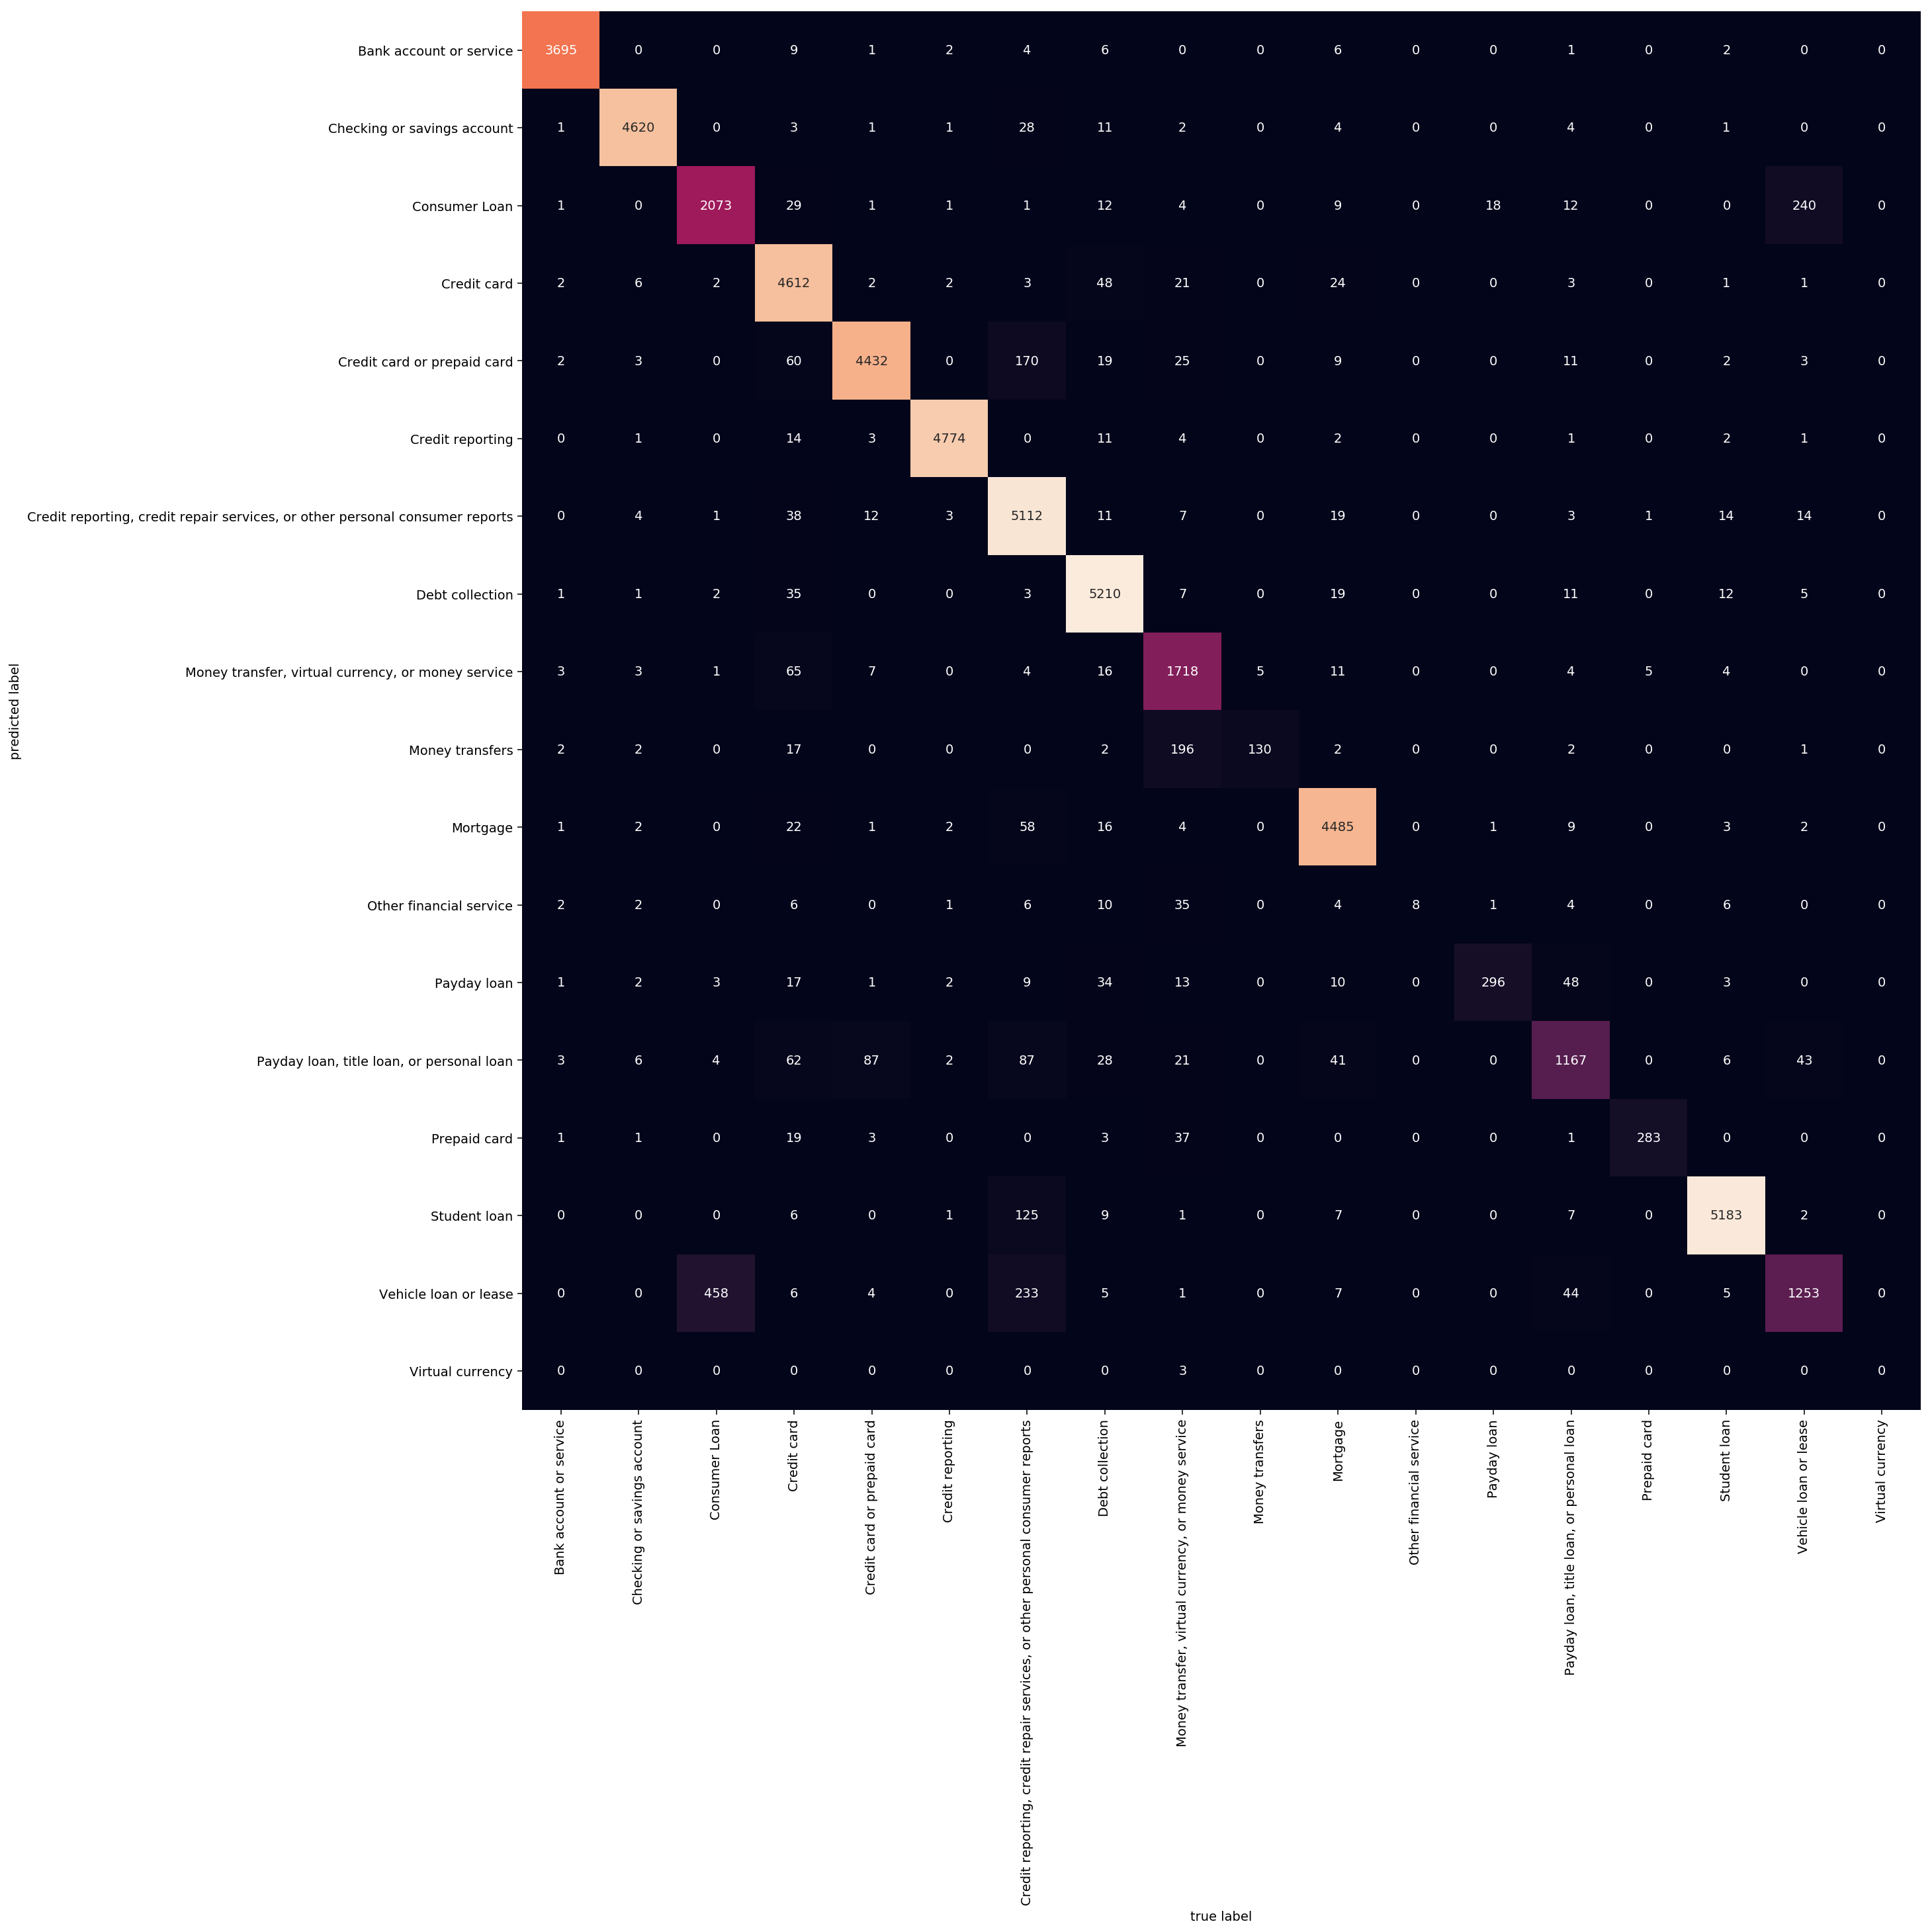

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from sklearn.metrics import confusion_matrix

labels = df_selected["Product"].unique()
labels.sort()
conf_matrix = confusion_matrix(test_predictions, Y_test)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=labels,
           yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');


rcParams['figure.figsize'] = 40, 40
rcParams['figure.dpi'] = 140
#plot_confusion_matrix(clf, principal_components_test, Y_test, xticks_rotation='vertical')